## Final indepenedent project CSE801
## Title: Population genetics simulation for the haploid fungal species using microsatellite markers 

## Introduction

Jie Wang

_Fusarium virguliforme_ is a fungal pathogen causing severe diseases on soybean, which is responsible for almost 300 million dollar yield loss every year. Despite the devastating consequences caused by this disease, epidemiology of this disease is merely studied. From 2012 to 2014, I have colledted almost 550 isolates of this pathogen from multiple locations of most soybean producing areas in the United States in order to study the epidemiology of this pathogen using population genetic techniques. Currently, all the isolates were genotypes using microsatellite (also known as __simple sequence repeat (SSR)__) genetic markers. The genetic diversity and structure were estimated for each of the sampling population. Due to the asexual reproduction nature of this fungal pathogen, many population genetics analytic tools are not applicable for my data analysis because of assumption violations. Therefore, I would like to develop a simulation tool to predict the founding age of the newly established population.

Microsatellites are the DNA based molecular markers that vary in length of its composed motif size ranged from 2-6 bp in length. The polymorphism of the marker is based on the repeat number of each microsatellite locus. I would run a simulation to test how many generations does it by starting from one genotype to achieve the level of current genetic diversity assuming no additional immigration.

### Comments from AH
>AH: Makes total sense, try to isolate single parameters that influence the diveristy like: total population size, mutation rate, death rate ... pick one of these parameters to perform a sweep. 

##  Expected functions to be relized:
* simulate sweep by year
* introduce mutation using stepwise mutation model (SMM)

### A few common parameters:

* Mutation rate: 10e-4 per generation
* Allele list example: [1,2,3,4]
* Mutation is randomly happened on one locus by changing the locus length of 1
* mutated allele list example: [2,2,3,4]

Total population contains hundreds

In [1]:
# import modules used in this project
%pylab inline
import random
import collections 
import math
import numpy as np       # imported for array manipulation
import time              # estimate runtime
import copy
from pandas import *     # Figures and data manipulation

Populating the interactive namespace from numpy and matplotlib


### Initial Parameters

In [2]:
# predefined variable numbers
numOfLoci    =   4          # number of loci
deathRate    =   0.8        # spore overwintering death rate
mutationRate =   0.0005     # between 10e-3 and 10e-4
alleleRange  =   (10, 40)   # allowed allele size range for microsatellite
popSizeLimit =   10 ** 5    # population size limit for one location
sweepRatio   =   0.88       # default death ratio for a sweep

### Isolate Class
Describe a isolate  
Desired functions():  
1. reproduce w/ mutation  
2. reproduce w/o mutation  
    

In [3]:
# create class for describe a fungal isolate
class Isolate():
    def __init__(self, randomAllele = True, alleles = []):
        self.numLoci = numOfLoci
        self.isolateID = ""
        self.geoLocation = ""
        if randomAllele:
            self.alleleList = random.sample(range(alleleRange[0],alleleRange[1]), numOfLoci)
        else:
            self.alleleList = alleles        
        self.genotype = "MLG: " + ".".join(map(str,self.alleleList))
        
    def reproduceWithoutMutation(self):
        if self.alleleList != []:
            return self
        else:
            print "Error Msg: No allele list assigned to this isolate"
    
    def reproduceWithMutation(self):
        if self.alleleList != []:
            alleleLength = len(self.alleleList)
            mutationLocus = random.randint(0, alleleLength-1) # randomly select one locus
            while self.alleleList[mutationLocus] < 5 : # allele size has to be more than 5
                mutationLocus = random.randint(0, alleleLength-1) 
            if random.uniform(0,1) < 0.50: # equal chance to increase or decrease length by 1
                self.alleleList[mutationLocus] += 1
            else:
                self.alleleList[mutationLocus] -= 1
            return self
        else:
            print "Error Msg: No aselfllele list assigned to this isolate"
    
#     def __str__(self):
#         return self.genotype

### Population class
Describe a population
Desired functions():  
1. sweep
2. start a population with certain number of individuals
3. reproduce a given number of generation
4, calculate allele frequency and can plot allele frequency if needed
5, 

In [4]:
class Population():
    def __init__(self):
        self.isolateList = list()
        # create a list with 4 empty lists
        self.lociList = [[] for _ in range(numOfLoci)]
        # create genotype list
        self.genotypeList = []
        # find unique genotypes
        self.uniqueMLG = []

    def addIsolate(self, isolate):
        self.isolateList.append(isolate)
        self.genotypeList.append(isolate.genotype)
        
    def getAlleleFreq(self):
        for i in range(0, numOfLoci):
            for ind in self.isolateList:
                self.lociList[i].append(ind.alleleList[i])
        lociSum = []
        sizesSum = []
        for i in range(0, len(self.lociList)):
            # alleleFreq = collections.Counter(X[i])
            locus, sizes = zip(*collections.Counter(self.lociList[i]).items())
            lociSum.append(locus)
            sizesSum.append(sizes)
        return(lociSum, sizesSum) 
    
    def graphAlleleFreq(self, locus = 0, pltTitle = "Allele Frequency"):
        alleleFreq = self.getAlleleFreq() 
        labels = alleleFreq[0][locus]
        values = alleleFreq[1][locus]
        indexes = np.arange(len(labels))
        width = 0.5
        plt.bar(indexes, values, width)
        plt.xticks(indexes + width * 0.7, labels)
        plt.xlabel("Allele Sizes (Locus{})".format(locus))
        plt.ylabel("Frequency")
        plt.title(pltTitle)
        plt.show()
                    
    def sweepPop(self, deathRate = sweepRatio, verbose = False):
        # functionm to simulate sweep
        # randomly kill 80-90% of its individuals
        if verbose:
            print "Reach population size limit, {0} individuals ({1}%) were removed\
            ".format(int(len(self.isolateList)*deathRate),round(deathRate*100,2))
        # randomly 
        for i in range(0,int(len(self.isolateList)*deathRate)):
            self.isolateList.pop(random.randrange(len(self.isolateList)))
        self.updateGenotypeList()
    
    def reproduceNumGens(self, numGen):
        for gen in range(0, numGen):
            if len(self.isolateList) > popSizeLimit:
                # print "reach population size limit"
                rate = random.uniform(0.75,0.85)
                self.sweepPop(deathRate = rate,verbose = True)
            for ind in range(0, len(self.isolateList)):
                if random.uniform(0,1.0) < mutationRate:
                    # print "there is a mutation."
                    tempind = self.isolateList[ind].reproduceWithMutation()
                    self.addIsolate(tempind)
                else:
                    tempind = self.isolateList[ind].reproduceWithoutMutation()
                    self.addIsolate(tempind)
        # print "update GenotypeList"
        self.updateGenotypeList()
        
    def updateGenotypeList(self):
        self.genotypeList = ["MLG: " + ".".join(map(str,isolateX.alleleList)) for isolateX in self.isolateList]
        self.uniqueMLG = list(sorted(set(self.genotypeList)))
        
    def diversityIndex(self):
        self.updateGenotypeList()
        freqL2 = []
        ShannonH = float()
        sumGenotypes = len(self.genotypeList)
        MLG, genoFreq = zip(*collections.Counter(self.genotypeList).items())
        for freq in genoFreq:
            freqL2.append((float(freq)/float(sumGenotypes))**2)
            hI = float(freq)*log(float(freq))
            ShannonH += hI
        diversitySimpson = float(sum(freqL2))
        diversityST = 1/diversitySimpson
        diversityShannon = -ShannonH 
        return(diversityST, diversitySimpson, diversityShannon)
    
    def __str__(self):
        ST, simpson, shannon = self.diversityIndex()
        return "There are {0} isolates in current population\n\
Genotypic diversity(MLG): {1}\n\
Genotypic diversity(Stoddart Taylor): {2}\n\
Genotypic diversity(Simpson): {3}\n\
Genotypic diversity(Shannon-Wiener): {4}\n\
".format(len(self.isolateList), len(self.uniqueMLG), ST, simpson,shannon)


### Simulations

In [5]:
start_time = time.time()
# initilize parameter and store list
initialPopSize = 2000
simulationYear = 20
numOfGenotypeL = []
StoTaylorL = []
SimpsonL =[]
ShannonL = []

# initial population with 2k isolates
Pop = Population()
for i in range(initialPopSize):
    Pop.addIsolate(Isolate())
initialPop = copy.deepcopy(Pop)
div1, div2, div3 = Pop.diversityIndex()
Pop.updateGenotypeList()
numOfGenotypeL.append(len(Pop.uniqueMLG))
StoTaylorL.append(div1)
SimpsonL.append(div2)
ShannonL.append(div3)
print Pop

for numYear in range(simulationYear): # do not simulate for too many years
    # determine how many generation per year
    numOfGen = random.randint(8,12)
    Pop.reproduceNumGens(numOfGen)
    Pop.updateGenotypeList()
    d1, d2, d3 = Pop.diversityIndex()
    numOfGenotypeL.append(len(Pop.uniqueMLG))
    StoTaylorL.append(d1)
    SimpsonL.append(d2)
    ShannonL.append(d3)
    if numYear < 1:
        print "{0} year passed".format(numYear+1)
    elif numYear >= 1:
        print "{0} years passed, {1} more years left\
        ".format(numYear+1, simulationYear-numYear-1)
print Pop
print "--- Job is done! ---"
print "--- {0}s seconds passed ---".format(int(time.time() - start_time))

There are 2000 isolates in current population
Genotypic diversity(MLG): 1991
Genotypic diversity(Stoddart Taylor): 1982.16055501
Genotypic diversity(Simpson): 0.0005045
Genotypic diversity(Shannon-Wiener): -12.4766492501

Reach population size limit, 102488 individuals (80.07%) were removed            
Reach population size limit, 79965 individuals (78.36%) were removed            
1 year passed
Reach population size limit, 149578 individuals (84.67%) were removed            
Reach population size limit, 90530 individuals (83.56%) were removed            
Reach population size limit, 120953 individuals (84.87%) were removed            
Reach population size limit, 131229 individuals (76.09%) were removed            
Reach population size limit, 136686 individuals (82.85%) were removed            
2 years passed, 18 more years left        
Reach population size limit, 85171 individuals (75.28%) were removed            
Reach population size limit, 89554 individuals (80.04%) were removed

#### The 20 years' simulation will take about 200 seconds.

### Plots for genotypic diversity over time

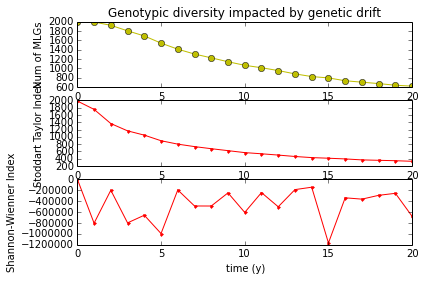

In [6]:
y1 = numOfGenotypeL
y2 = StoTaylorL
y3 = ShannonL

x = range(0,numYear+2)

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'yo-')
plt.title('Genotypic diversity impacted by genetic drift')
plt.ylabel('Num of MLGs')

plt.subplot(3, 1, 2)
plt.plot(x, y2, 'r.-')
plt.ylabel('Stoddart Taylor Index')

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'r.-')
plt.xlabel('time (y)')
plt.ylabel('Shannon-Wienner Index')

plt.show()

### change of the allele frequency at a given loci

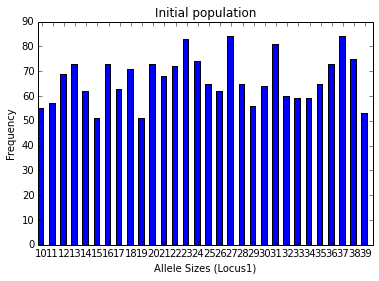

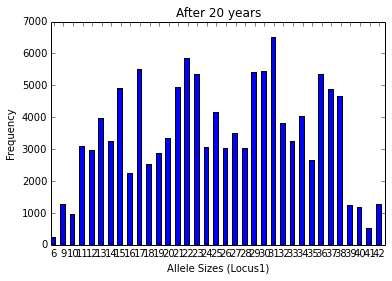

In [7]:
initialPop.graphAlleleFreq(1, pltTitle = "Initial population")
Pop.graphAlleleFreq(1, pltTitle = "After {} years".format(numYear+1))

### Conclusions
This simulation decribed a population with genetic drift and sponteneous mutation with assumptions of no other evolutionary forces. The genotypic diversity kept decreasing along with the time. However, this simulation contradict with the temporal sampling data genotypic diversity level observed in the field. Therefore, there should be other significant evolutionary forces that maintained a high genotypic diversity level.

# Please do not evaluate the following code.
### Jie's Sandbox for testing codes

In [397]:
isolateTest = Isolate(randomAllele=False, alleles=[22,22,22,22])
print isolateTest.genotype

MLG: 22.22.22.22


There are 2001 isolates in current population
Genotypic diversity(MLG): 1998
Genotypic diversity(Stoddart Taylor): 1995.01793722
Genotypic diversity(Simpson): 0.000501248626062
Genotypic diversity(Shannon-Wiener): -4.15888308336



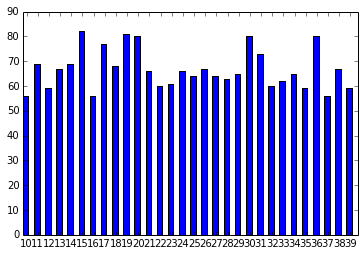

Reach population size limit 108619 individuals (84.82%) were removed            
Reach population size limit 120852 individuals (77.69%) were removed            
Reach population size limit 111229 individuals (80.12%) were removed            
Reach population size limit 87426 individuals (79.18%) were removed            
Reach population size limit 144135 individuals (78.38%) were removed            
Reach population size limit 129931 individuals (81.71%) were removed            
Reach population size limit 96608 individuals (83.05%) were removed            
Reach population size limit 130045 individuals (82.45%) were removed            
Reach population size limit 93833 individuals (84.74%) were removed            
Reach population size limit 114905 individuals (84.99%) were removed            
Reach population size limit 125194 individuals (77.14%) were removed            
Reach population size limit 122888 individuals (82.8%) were removed            
Reach population size limit 7730

In [448]:
start_time = time.time()
# Test code
population1 =  Population()
population1.addIsolate(Isolate())

for i in range(2000):
    population1.addIsolate(Isolate())
population1.updateGenotypeList()
print population1
#print population1.genotypeList

alleleFreq = population1.getAlleleFreq() 

for i in [1]:
    labels = alleleFreq[0][i]
    values = alleleFreq[1][i]

    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.7, labels)
    plt.show()
# print "{}, and \n{}, {}".format(population1, population1.isolateList[1],  population1.isolateList[0])

population1.reproduceNumGens(50)

alleleFreq = population1.getAlleleFreq() 

print population1


print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# count frequency from a list of integers
x = collections.Counter([20,20,20])
x.most_common(1)
print range(0,10)

L = [20,20,20,20]
L1 = [10,20,30,20]
L2 = [10,11,23,33]
grandL = [L, L1, L2]
# print random.sample(xrange(len(grandL)), int(len(grandL)*0.95))
#         sweepList = random.sample(xrange(len(self.isolateList)), 
#                                   int(len(self.isolateList)*deathRate))
for x in range(1):
    print random.randrange(20)
    
print random.sample(range(10,40), 4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
14
[25, 31, 30, 20]


In [20]:
print 

(415, 370, 600, 165, 366, 940, 947, 581, 1293, 921, 355, 371, 783, 545, 538, 743, 703, 539, 369, 376, 707, 525, 561, 387, 899, 185, 937, 549, 195)


[[], [], [], []]
[[20, 10, 10], [20, 20, 11], [20, 30, 23], [20, 20, 33]]
3072
(10, 20) (2, 1)
(11, 20) (1, 2)
(20, 30, 23) (1, 1, 1)
(33, 20) (1, 2)
[0 1] (1, 2)


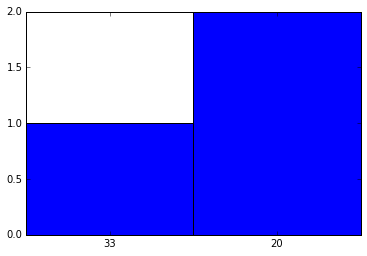

In [115]:
# create a empty list with four sub empty lists
# and put the number based on the number of 
L = [20,20,20,20]
L1 = [10,20,30,20]
L2 = [10,11,23,33]
grandL = [L, L1, L2]
X = [[] for _ in range(4)]
print X

for i in range(0,len(grandL)):
    for j in range(0,len(grandL[1])):
        X[j].append(grandL[i][j])
print X
for gen in range(0,10):
    for ind in range(0,len(grandL)):
        grandL.append(grandL[ind])
print len(grandL)

for i in range(0, len(X)):
    # alleleFreq = collections.Counter(X[i])
    labels, values = zip(*collections.Counter(X[i]).items())
    print labels, values

indexes = np.arange(len(labels))
width = 1
print indexes, values
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()


In [444]:
print range(0,numYear+2)
print numOfGenotypeL

[0, 1, 2, 3, 4, 5]
[1997, 1995, 1964, 1889, 1803, 1679]
